# Part2. Model design 1 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import SpecificityAtSensitivity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [11]:
#load the original data
df1=pd.read_csv("../Data/kag_risk_factors_cervical_cancer.csv")

#load the processed datasets:
X_train=pd.read_csv("../Data/X_train_preprocessed.csv")
X_test=pd.read_csv("../Data/X_test_preprocessed.csv")
X_validate=pd.read_csv("../Data/X_validate_preprocessed.csv")
y_train=pd.read_csv("../Data/y_train_preprocessed.csv")
y_test=pd.read_csv("../Data/y_test_preprocessed.csv")
y_validate=pd.read_csv("../Data/y_validate_preprocessed.csv")

X_t_whole=pd.read_csv("../Data/X_t_whole.csv")
y_t_whole=pd.read_csv("../Data/y_t_whole.csv")

In [12]:
#show the processed X_train file:
X_train.tail(2)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology
654,-0.587772,-0.879301,-0.001620,-0.137403,0.0,-0.307318,-0.208218,1.0,-0.510729,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
655,0.355828,-0.302480,-1.418945,0.561330,1.0,4.945406,1.145403,0.0,-0.556973,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [13]:
# and the labels:
y_train.tail(2)

,Biopsy
654,0
655,1


## Model

Let's try a neural network model and see if the recall increases:

Imbalance in the total dataset:

In [14]:
neg, pos = np.bincount(df1['Biopsy'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Examples:
    Total: 858
    Positive: 55 (6.41% of total)



In [15]:

model = Sequential() 

#Input layer
model.add(Dense(units=500, 
            input_dim=31, # I have 31 features
            kernel_initializer='uniform', # all features have the same weight
            activation='relu'
               ))
model.add(Dropout(0.5))  #randomly sets 0.5 units to 0. To prevent overfitting
#Hidden layer 1
model.add(Dense(units=500,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Hidden layer 2
model.add(Dense(units=500,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Hidden layer 3
model.add(Dense(units=500,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Output layer
model.add(Dense(units=1,
                kernel_initializer='uniform', 
                activation='sigmoid'))


print(model.summary()) #for showing the structure and parameters

# Defining how to measure performance
model.compile(loss='binary_crossentropy',   
              optimizer='adam',
               metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),'accuracy'])


# Train the model
# Verbose=2, showing loss and accuracy change timely
#remove batch_size, the dataset is small. ->  training the network with the whole ds increases recall.
train_history = model.fit(x=X_train, y=y_train,  
                          validation_split=0.2, epochs=50, verbose=2) 



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               16000     
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               2

Epoch 38/50
17/17 - 0s - loss: 0.0208 - precision: 0.9167 - recall: 0.9167 - accuracy: 0.9885 - val_loss: 0.3623 - val_precision: 0.5000 - val_recall: 0.2000 - val_accuracy: 0.9621
Epoch 39/50
17/17 - 0s - loss: 0.0244 - precision: 0.9714 - recall: 0.9444 - accuracy: 0.9943 - val_loss: 0.2009 - val_precision: 0.6667 - val_recall: 0.4000 - val_accuracy: 0.9697
Epoch 40/50
17/17 - 0s - loss: 0.0120 - precision: 0.9459 - recall: 0.9722 - accuracy: 0.9943 - val_loss: 0.1782 - val_precision: 0.7500 - val_recall: 0.6000 - val_accuracy: 0.9773
Epoch 41/50
17/17 - 0s - loss: 0.0456 - precision: 0.9091 - recall: 0.8333 - accuracy: 0.9828 - val_loss: 0.3570 - val_precision: 0.5000 - val_recall: 0.2000 - val_accuracy: 0.9621
Epoch 42/50
17/17 - 0s - loss: 0.0328 - precision: 0.9167 - recall: 0.9167 - accuracy: 0.9885 - val_loss: 0.2073 - val_precision: 0.6667 - val_recall: 0.4000 - val_accuracy: 0.9697
Epoch 43/50
17/17 - 0s - loss: 0.0188 - precision: 0.8974 - recall: 0.9722 - accuracy: 0.9905 -

In [16]:
def show_train_history(train_history,train,validation):
    '''
    Function to plot the metrics evolution during the network training
    and validation
    '''
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

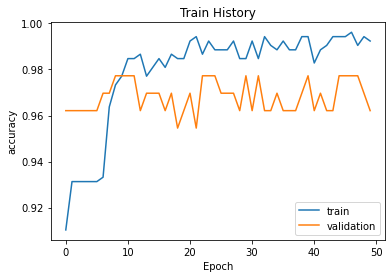

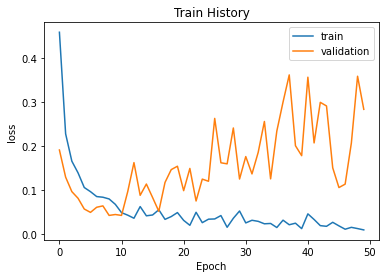

In [17]:
#visualize the loss and accuracy after each epoch
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')



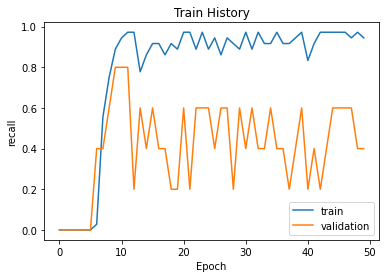

In [19]:
#visualize recall, what we really want to increase, after each epoch
show_train_history(train_history,'recall','val_recall')



###  The recall increases after epoch 10, but it never gets higher than 0.6. We have an imbalenced sample

### Look at the confussion matrix:

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
4/4 [==============================] - 0s 7ms/step


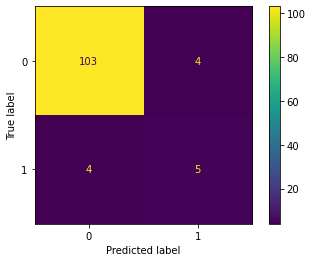

In [20]:
y_pred_test=model.predict_classes(X_test, verbose=1)
cm = confusion_matrix(y_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(cm).plot()

3/3 [==============================] - 0s 8ms/step


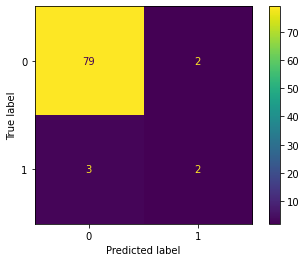

In [21]:
y_pred_val=model.predict_classes(X_validate, verbose=1)
cm = confusion_matrix(y_validate, y_pred_val)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [22]:
scores = model.evaluate(X_test, y_test)
print('\n')
print('recall=',scores[2])



4/4 [==============================] - 0s 4ms/step - loss: 0.8224 - precision: 0.5556 - recall: 0.5556 - accuracy: 0.9310


recall= 0.5555555820465088


### Recall is still similar to what LR accomplished. We need a model designed specifically for imbalanced datasets. Let's try something new in "cervix_project_2_Model_design_2"